In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Count Individuals on SSL by Arrest Location Census Tract

According to the [documentation on the data portal](https://data.cityofchicago.org/Public-Safety/Strategic-Subject-List/4aki-r3np), the "CENSUS_TRACT" field represents the census tract of the individual's latest arrest. There is some inconsistency in the listed tracts, so it's cleaned up here with the results plotted at the bottom. 

This shows a pretty clear, but unfortunately unsurprising focus on arrests on the loop, and then on the West and South sides in predominantly Black neighborhoods. This is made more distinct by focusing on individuals with SSL scores greater than or equal to 250.

In [2]:
ssl_df = pd.read_csv('data/Strategic_Subject_List.csv', dtype={'CENSUS_TRACT': 'object'})

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
ssl_df['CENSUS_TRACT'].unique().shape

(813,)

In [5]:
short_census = ssl_df.loc[ssl_df['CENSUS_TRACT'].str.len() < 10].copy()
short_census.shape

(3528, 48)

In [6]:
short_census['CENSUS_TRACT'].unique()

array(['0', '161100', '839100', '980000', '280100', '330100', '351000',
       '411000', '832300', '460100', '830900'], dtype=object)

In [7]:
short_census_tracts = short_census['CENSUS_TRACT'].unique().tolist()[1:]
# Ignoring '0'
short_census_tracts

['161100',
 '839100',
 '980000',
 '280100',
 '330100',
 '351000',
 '411000',
 '832300',
 '460100',
 '830900']

In [8]:
long_tracts = list(filter(lambda x: isinstance(x, str), ssl_df['CENSUS_TRACT'].unique().tolist()))
long_tracts = list(filter(lambda x: len(x) > 8, long_tracts))
len(long_tracts)

801

In [9]:
[c for c in long_tracts if any([c.endswith(t) for t in short_census_tracts])]

['17031161100',
 '17031280100',
 '17031330100',
 '17031351000',
 '17031411000',
 '17031460100',
 '17031830900',
 '17031832300',
 '17031839100',
 '17031980000']

In [10]:
col_map = {}
for c in short_census_tracts:
    for t in long_tracts:
        if t.endswith(c):
            col_map[c] = t
col_map

{'161100': '17031161100',
 '280100': '17031280100',
 '330100': '17031330100',
 '351000': '17031351000',
 '411000': '17031411000',
 '460100': '17031460100',
 '830900': '17031830900',
 '832300': '17031832300',
 '839100': '17031839100',
 '980000': '17031980000'}

In [11]:
def convert_short_tracts(val):
    if col_map.get(val):
        return col_map[val]
    else:
        return val
    
ssl_df['CENSUS_TRACT'] = ssl_df['CENSUS_TRACT'].apply(convert_short_tracts)
ssl_df.head()

,SSL_SCORE,PREDICTOR_RAT_AGE_AT_LATEST_ARREST,PREDICTOR_RAT_VICTIM_SHOOTING_INCIDENTS,PREDICTOR_RAT_VICTIM_BATTERY_OR_ASSAULT,PREDICTOR_RAT_ARRESTS_VIOLENT_OFFENSES,PREDICTOR_RAT_GANG_AFFILIATION,PREDICTOR_RAT_NARCOTIC_ARRESTS,PREDICTOR_RAT_TREND_IN_CRIMINAL_ACTIVITY,PREDICTOR_RAT_UUW_ARRESTS,SEX_CODE_CD,...,RAW_HEAT_SCORE,STATUS_I,PRE_RAW_HEAT_SCORE,TRAP_FLAGS,SSL_FLAGS,LATITUDE,LONGITUDE,CENSUS_TRACT,COMMUNITY_AREA,LOCATION
0,500,20-30,0,1,4,1,1,1.0,1,M,...,0.14196,Y,14196,NaN,24.0,NaN,NaN,NaN,,NaN
1,500,20-30,0,9,1,1,0,1.0,0,M,...,0.14511,Y,14511,NaN,8.0,NaN,NaN,NaN,,NaN
2,500,less than 20,1,2,1,1,3,1.0,0,M,...,0.12982,Y,12982,NaN,8.0,NaN,NaN,NaN,,NaN
3,500,less than 20,1,1,4,1,0,1.6,1,M,...,0.13110,Y,13110,NaN,NaN,NaN,NaN,NaN,,NaN
4,500,less than 20,0,0,5,0,0,1.3,3,M,...,0.12874,Y,12874,NaN,NaN,NaN,NaN,NaN,,NaN


In [12]:
ssl_df['CENSUS_TRACT'].unique().shape

(803,)

In [17]:
tract_group = ssl_df.groupby('CENSUS_TRACT')['SSL_SCORE'].count()
tract_group_df = pd.DataFrame(tract_group).reset_index()

ssl_gte_250 = ssl_df.loc[ssl_df['SSL_SCORE'] >= 250].copy()
tract_group_gte_250 = ssl_gte_250.groupby('CENSUS_TRACT')['SSL_SCORE'].count()
tract_group_gte_250_df = pd.DataFrame(tract_group_gte_250).reset_index()

In [19]:
tract_df = gpd.read_file('data/chi_census_tracts.geojson')
tract_df.head()

,commarea,commarea_n,countyfp10,geoid10,geometry,name10,namelsad10,notes,statefp10,tractce10
0,44,44,031,17031842400,(POLYGON ((-87.62404799998049 41.7302169999839...,8424,Census Tract 8424,,17,842400
1,59,59,031,17031840300,(POLYGON ((-87.6860799999848 41.82295600001154...,8403,Census Tract 8403,,17,840300
2,34,34,031,17031841100,(POLYGON ((-87.62934700001182 41.8527970000265...,8411,Census Tract 8411,,17,841100
3,31,31,031,17031841200,(POLYGON ((-87.68813499997718 41.8556909999909...,8412,Census Tract 8412,,17,841200
4,28,28,031,17031838200,(POLYGON ((-87.66781999997529 41.8741839999791...,8382,Census Tract 8382,,17,838200


In [29]:
tract_df.info(verbose=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 10 columns):
commarea      801 non-null object
commarea_n    801 non-null object
countyfp10    801 non-null object
geoid10       801 non-null object
geometry      801 non-null object
name10        801 non-null object
namelsad10    801 non-null object
notes         801 non-null object
statefp10     801 non-null object
tractce10     801 non-null object
dtypes: object(10)
memory usage: 62.7+ KB


In [30]:
tract_merge_df = tract_df.merge(tract_group_df, left_on='geoid10', right_on='CENSUS_TRACT', how='left')
tract_merge_df.rename(columns={'SSL_SCORE': 'ssl_count'}, inplace=True)
tract_merge_df.head()

,commarea,commarea_n,countyfp10,geoid10,geometry,name10,namelsad10,notes,statefp10,tractce10,CENSUS_TRACT,ssl_count
0,44,44,031,17031842400,(POLYGON ((-87.62404799998049 41.7302169999839...,8424,Census Tract 8424,,17,842400,17031842400,1641.0
1,59,59,031,17031840300,(POLYGON ((-87.6860799999848 41.82295600001154...,8403,Census Tract 8403,,17,840300,17031840300,248.0
2,34,34,031,17031841100,(POLYGON ((-87.62934700001182 41.8527970000265...,8411,Census Tract 8411,,17,841100,17031841100,371.0
3,31,31,031,17031841200,(POLYGON ((-87.68813499997718 41.8556909999909...,8412,Census Tract 8412,,17,841200,17031841200,305.0
4,28,28,031,17031838200,(POLYGON ((-87.66781999997529 41.8741839999791...,8382,Census Tract 8382,,17,838200,17031838200,451.0


In [31]:
tract_merge_250_df = tract_df.merge(tract_group_gte_250_df, left_on='geoid10', right_on='CENSUS_TRACT', how='left')
tract_merge_250_df.rename(columns={'SSL_SCORE': 'ssl_count'}, inplace=True)
tract_merge_250_df.head()

,commarea,commarea_n,countyfp10,geoid10,geometry,name10,namelsad10,notes,statefp10,tractce10,CENSUS_TRACT,ssl_count
0,44,44,031,17031842400,(POLYGON ((-87.62404799998049 41.7302169999839...,8424,Census Tract 8424,,17,842400,17031842400,1201.0
1,59,59,031,17031840300,(POLYGON ((-87.6860799999848 41.82295600001154...,8403,Census Tract 8403,,17,840300,17031840300,187.0
2,34,34,031,17031841100,(POLYGON ((-87.62934700001182 41.8527970000265...,8411,Census Tract 8411,,17,841100,17031841100,260.0
3,31,31,031,17031841200,(POLYGON ((-87.68813499997718 41.8556909999909...,8412,Census Tract 8412,,17,841200,17031841200,245.0
4,28,28,031,17031838200,(POLYGON ((-87.66781999997529 41.8741839999791...,8382,Census Tract 8382,,17,838200,17031838200,290.0


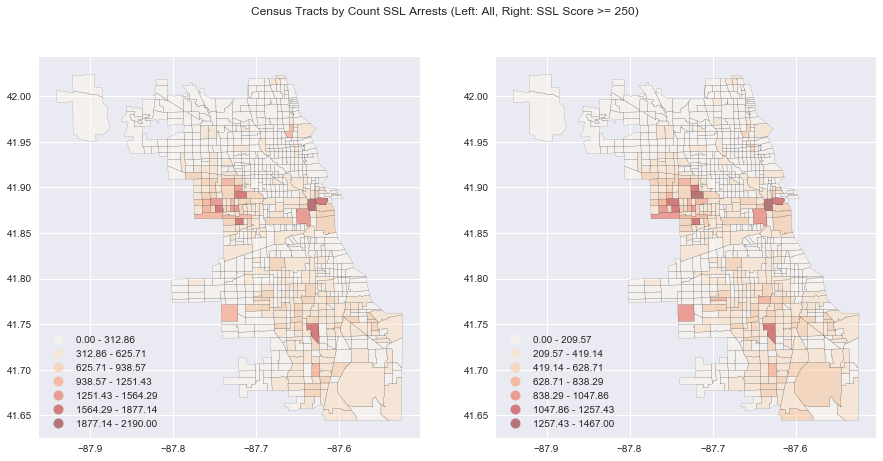

In [38]:
plt.rcParams["figure.figsize"] = [15, 7]
fig, axs = plt.subplots(1,2)

tract_merge_df['ssl_count'].fillna(0, inplace=True)
tract_merge_250_df['ssl_count'].fillna(0, inplace=True)

plt.suptitle('Census Tracts by Count SSL Arrests (Left: All, Right: SSL Score >= 250)')

tract_merge_df.plot(column='ssl_count', scheme='equal_interval', k=7, 
                    cmap='OrRd', ax=axs[0], linewidth=0.1, legend=True)
tract_merge_250_df.plot(column='ssl_count', scheme='equal_interval', k=7, 
                        cmap='OrRd', ax=axs[1], linewidth=0.1, legend=True)